In [1]:
# 設置與 Google Drive 的掛載，用於存取數據與保存結果
from google.colab import drive
drive.mount('/gdrive')  # 掛載 Google Drive 到指定路徑
from pathlib import Path
Path("/gdrive/MyDrive/Colab Notebooks/").mkdir(parents=True, exist_ok=True)  # 確保目錄存在

Mounted at /gdrive


In [2]:
# 引入必要的模組
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib

# 加載處理後的訓練數據
X = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/processed_train_X.csv')  # 特徵數據
y = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/processed_train_y.csv')  # 標籤數據
Path("/gdrive/MyDrive/Colab Notebooks/evaluation/").mkdir(parents=True, exist_ok=True)  # 創建評估結果目錄

In [3]:
# 定義評估模型的函數
def evaluate_model(model, X, y):
    """
    使用 5 折交叉驗證評估模型的性能，計算 Macro F1 和 AUROC 指標。
    並生成每個類別的平均 ROC 曲線。

    參數：
    - model: 要評估的分類模型。
    - X: 特徵數據集。
    - y: 標籤數據。

    返回：
    - avg_auroc: 平均 AUROC。
    - avg_f1_macro: 平均 Macro F1。
    - mean_fpr: 平均假陽性率 (FPR)。
    - mean_tprs: 各類別的平均真陽性率 (TPR)。
    """
    y = y.squeeze()  # 確保 y 為 Series（若是單列 DataFrame）

    # 如果 y 為字串或類別型，轉換為數字
    if y.dtype == 'object' or y.dtype == 'category':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # 使用 OneVsRestClassifier 包裝模型，支援多類別機率預測
    model = OneVsRestClassifier(model)

    # 設置 5 折分層交叉驗證
    cv = StratifiedKFold(n_splits=5)
    auroc_scores = []  # 儲存每折的 AUROC 分數
    f1_macro_scores = []  # 儲存每折的 F1-Macro 分數
    mean_fpr = np.linspace(0, 1, 100)  # 定義統一的 FPR 範圍
    tprs = {i: [] for i in np.unique(y)}  # 儲存每個類別的 TPR

    for train_idx, test_idx in cv.split(X, y):
        # 使用訓練數據進行模型訓練
        model.fit(X.iloc[train_idx], y[train_idx])

        # 預測測試數據的機率分布
        y_pred_prob = model.predict_proba(X.iloc[test_idx])

        # 計算 AUROC
        auroc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr', average='macro')
        auroc_scores.append(auroc)

        # 預測測試數據的類別
        y_pred = model.predict(X.iloc[test_idx])

        # 計算 F1-Macro
        f1_macro = f1_score(y[test_idx], y_pred, average='macro')
        f1_macro_scores.append(f1_macro)

        # 計算每個類別的 ROC 曲線
        for i, class_label in enumerate(np.unique(y)):
            fpr, tpr, _ = roc_curve(y[test_idx] == class_label, y_pred_prob[:, i])
            tprs[class_label].append(np.interp(mean_fpr, fpr, tpr))  # 插值對齊 FPR
            tprs[class_label][-1][0] = 0.0  # 起點為 (0, 0)

    # 計算平均 AUROC 和 F1-Macro
    avg_auroc = np.mean(auroc_scores)
    avg_f1_macro = np.mean(f1_macro_scores)

    # 計算每個類別的平均 TPR
    mean_tprs = {class_label: np.mean(tpr_list, axis=0) for class_label, tpr_list in tprs.items()}
    for tpr in mean_tprs.values():
        tpr[-1] = 1.0  # 終點為 (1, 1)

    return avg_auroc, avg_f1_macro, mean_fpr, mean_tprs


In [4]:
# 儲存模型的特徵重要性
def save_top_features(model, X, model_name):
    """
    儲存模型的前 20 個重要特徵到 CSV 檔案。

    參數：
    - model: 訓練好的模型（需支援 feature_importances_）。
    - X: 特徵數據集，用於提取列名。
    - model_name: 模型名稱，用於命名輸出的 CSV 文件。
    """
    if hasattr(model, "feature_importances_"):  # 確認模型支援特徵重要性
        feature_importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(20)

        filename = f"/gdrive/MyDrive/Colab Notebooks/evaluation/importances/{model_name}_top_20_features.csv"
        feature_importances.to_csv(filename, index=False)
        print(f"Top 20 features for {model_name} saved to {filename}")
        return feature_importances
    else:
        print(f"Model {model_name} does not support feature importances.")
        return None

In [5]:
# 保存模型到文件
def save_model(model, model_name):
    """
    將模型保存到 .joblib 文件。

    參數：
    - model: 訓練好的模型。
    - model_name: 模型名稱，用於命名輸出的文件。
    """
    filename = f"/gdrive/MyDrive/Colab Notebooks/models/{model_name}_model.joblib"
    joblib.dump(model, filename)
    print(f"Model {model_name} saved to {filename}")

In [6]:
# 繪製 ROC 曲線與 F1-Score 條形圖
def plot_results(results):
    """
    繪製 ROC 曲線（包括每個類別的曲線）和 F1-Score 條形圖。

    參數：
    - results: 包含每個模型的 AUROC、Macro F1、平均 FPR 和 TPR 的字典。
    """
    models = list(results.keys())
    f1_scores = [results[model]['F1_Macro'] for model in models]

    # 繪製 ROC 曲線
    plt.figure(figsize=(8, 6))
    for model in models:
        fpr = results[model]['mean_fpr']
        tprs = results[model]['mean_tpr']
        for class_label, mean_tpr in tprs.items():
            roc_auc = auc(fpr, mean_tpr)
            plt.plot(fpr, mean_tpr, label=f'{model} - Class {class_label} (AUROC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance Level")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'/gdrive/MyDrive/Colab Notebooks/evaluation/AUROC_plot.png')

    # 繪製 Macro F1 條形圖
    plt.figure(figsize=(10, 5))
    plt.bar(models, f1_scores, color='lightgreen')
    plt.title("Average Macro F1-Score by Model")
    plt.xlabel("Model")
    plt.ylabel("Average Macro F1-Score")
    plt.tight_layout()
    plt.savefig('/gdrive/MyDrive/Colab Notebooks/evaluation/f1_score_plot.png')

In [9]:
# 定義要使用的模型
from sklearn.ensemble import GradientBoostingClassifier

# 引入必要的庫進行超參數調優
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 定義模型列表
models_to_run = ['GradientBoosting']  # 要評估的模型名稱
results = {}  # 儲存每個模型的結果

# 設定超參數搜索範圍
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', 'log2', None],  # 移除了 'auto'
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}


# 初始化模型字典
model_dict = {}

# 進行超參數調優
print("Performing hyperparameter tuning for GradientBoosting...")
gbc = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=50,  # 根據資源情況調整
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1  # 使用所有可用的CPU核心
)

random_search.fit(X, y.values.ravel())
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳參數建立模型
best_model = random_search.best_estimator_
model_dict['GradientBoosting'] = best_model

Performing hyperparameter tuning for GradientBoosting...
Best parameters found:  {'learning_rate': 0.18971083770541586, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 17, 'n_estimators': 198, 'subsample': 0.9920991510265951}


Evaluating GradientBoosting...
GradientBoosting - AUROC: 0.9357, Macro F1-Score: 0.7115
Top 20 features for GradientBoosting saved to /gdrive/MyDrive/Colab Notebooks/evaluation/importances/GradientBoosting_top_20_features.csv
                               Feature  Importance
0                                  Age    0.266118
9   family_history_with_overweight_yes    0.079558
10                         Gender_Male    0.076338
1                                  FAF    0.076163
3                                  NCP    0.069630
2                                 CH2O    0.059044
5                                 FCVC    0.051995
6                      CAEC_Frequently    0.051895
4                                  TUE    0.047881
14                             CALC_no    0.045028
7                       CAEC_Sometimes    0.042428
11                            FAVC_yes    0.041234
13                      CALC_Sometimes    0.039886
15                        outlier_flag    0.023361
8        

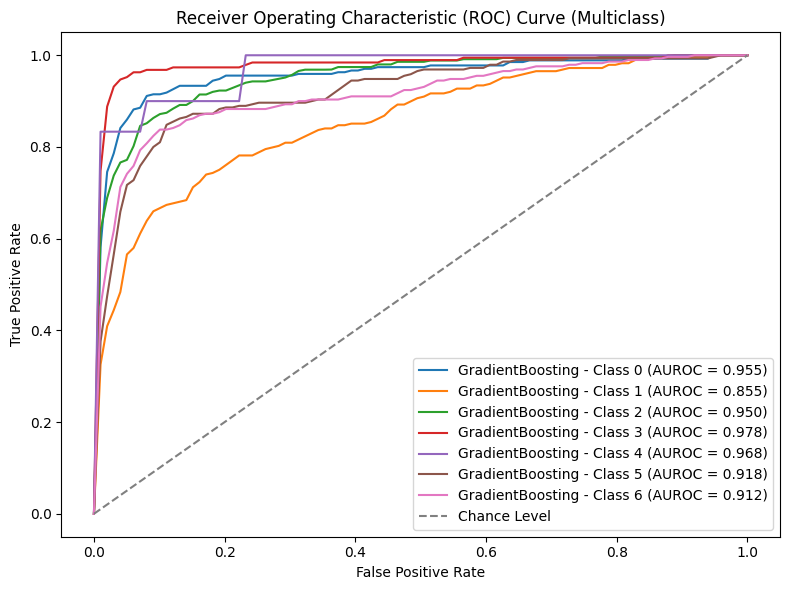

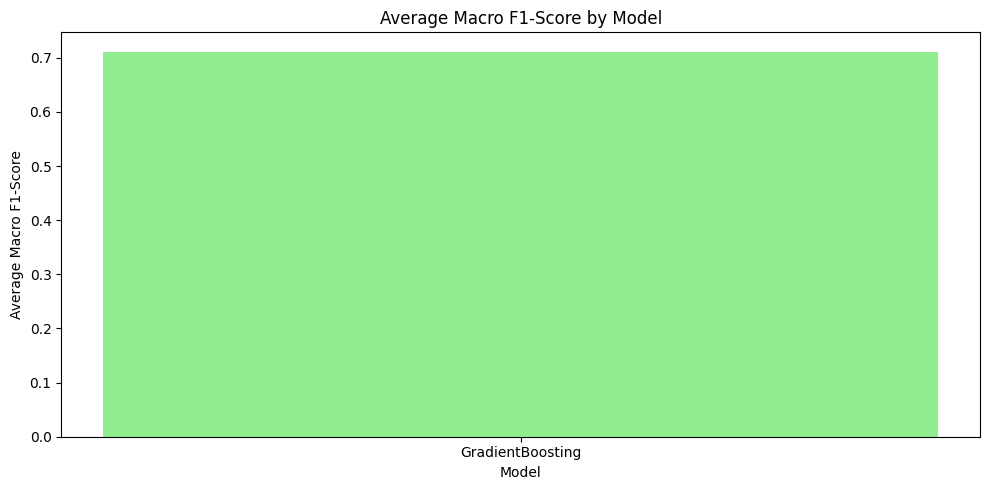

In [8]:
# 評估模型
for model_name in models_to_run:
    if model_name in model_dict:
        print(f"Evaluating {model_name}...")
        model = model_dict[model_name]
        avg_auroc, avg_f1_macro, mean_fpr, mean_tpr = evaluate_model(model, X, y)
        results[model_name] = {'AUROC': avg_auroc, 'F1_Macro': avg_f1_macro, 'mean_fpr': mean_fpr, 'mean_tpr': mean_tpr}
        print(f"{model_name} - AUROC: {avg_auroc:.4f}, Macro F1-Score: {avg_f1_macro:.4f}")

        # 儲存特徵重要性
        top_features = save_top_features(model, X, model_name)
        if top_features is not None:
            print(top_features)

        # 保存模型
        save_model(model, model_name)

# 繪製模型性能圖表
plot_results(results)